# SIR Model for Viral Marketing

In [1]:
#from __future__ import print_function
from decimal import Decimal
from datetime import timedelta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
import pandas as pd
from tabulate import tabulate
from scipy.stats import poisson

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import clear_output

from SimCAD.configuration import Configuration
from SimCAD.configuration.utils import exo_update_per_ts, proc_trigger, bound_norm_random, \
    ep_time_step
from SimCAD.engine import ExecutionMode, ExecutionContext, Executor

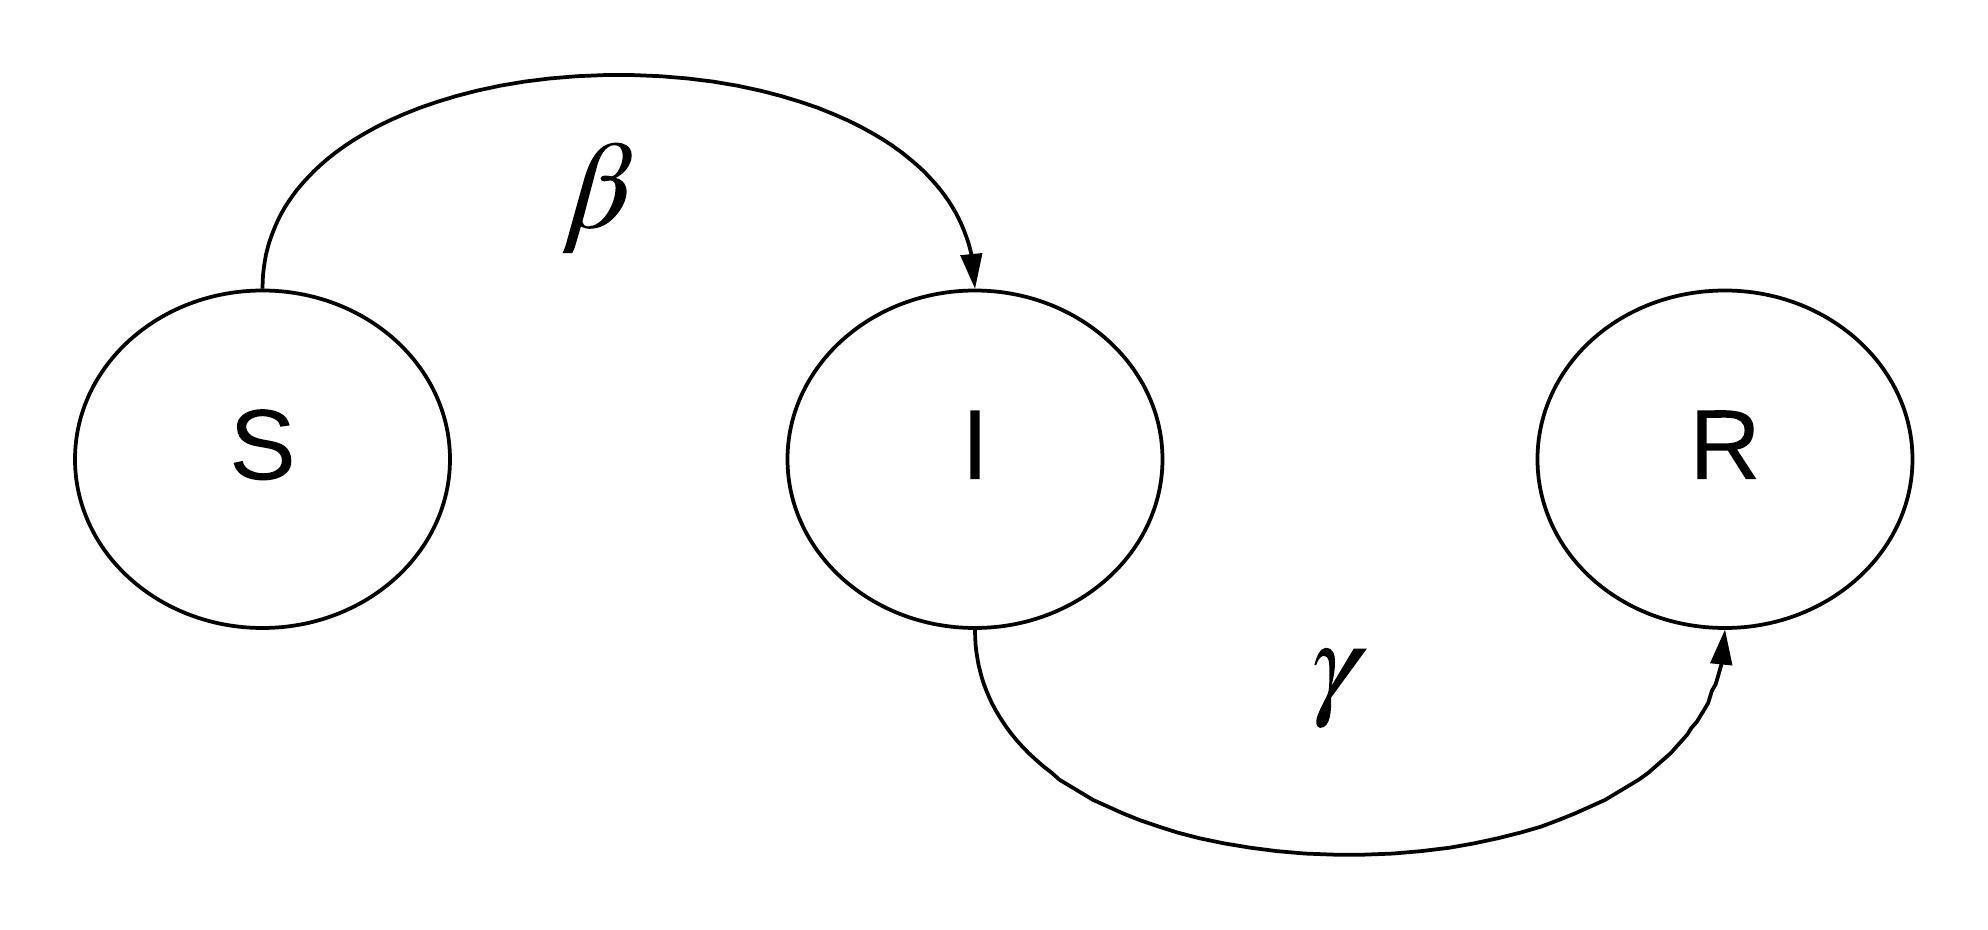

In [2]:
from IPython.display import Image
Image(filename='SIR0.jpeg')

In [3]:
#Simulation Configuration
#N is the number of experiments
#T is the discrete time range for each experiment
sim_config = {
    'N': 1,
    'T': range(100)
}

In [4]:
#Definte the timescale per period of time
ts_format = '%Y-%m-%d %H:%M:%S'
t_delta = timedelta(days=30, minutes=0, seconds=0)
def time_model(step, sL, s, _input):
    y = 'timestamp'
    x = ep_time_step(s, dt_str=s['timestamp'], fromat_str=ts_format, _timedelta=t_delta)
    return (y, x)

#declare the timestamp as an exogenous state variable
exogenous_states = exo_update_per_ts(
    {
    'timestamp': time_model
    }
)

In this section we define the initial conditions for the system; when running Monte Carlo simulations, each experiment will start from this initial state. Seed when defined makes experiments with random processes repeatable.

In [5]:
#declare system starting state
initial_condition = {
    'Budget': float(500),
    'Ps': float(1000),
    'Pi': float(10),
    'Pr': float(0),
    'beta': float(0.05), # contact rate between S and I
    'gamma': float(0.20), # recover rate from I to R
    'timestamp': '2019-01-01 00:00:00'
}

#these features not used in this model
seed = {}
env_processes = {}

In [6]:
# System Parameters
epsilon = 0.03 #portion of the subscription fee allocated to budget
subscription_fee = 10.0 #revenue per user per period
incentive_cost = 10.0 #cost per unit for marketing or adption incentive (increases infection rate) 
stickiness_cost = 5.0 #cost per unit for retention/stickiness (decreases recovery rate)
incentive_degredation_rate = 0.01 #rate at which the infection rate decays naturally
stickiness_degredation_rate = 0.01 #rate at which the recover rate increases naturally

Below is a System Diagram comprises of Stocks (states) and flows (rates of change of states). Note the SIR model for viral marketing is a second order differential equation with budget constrained actions to change the infection and recover rates.

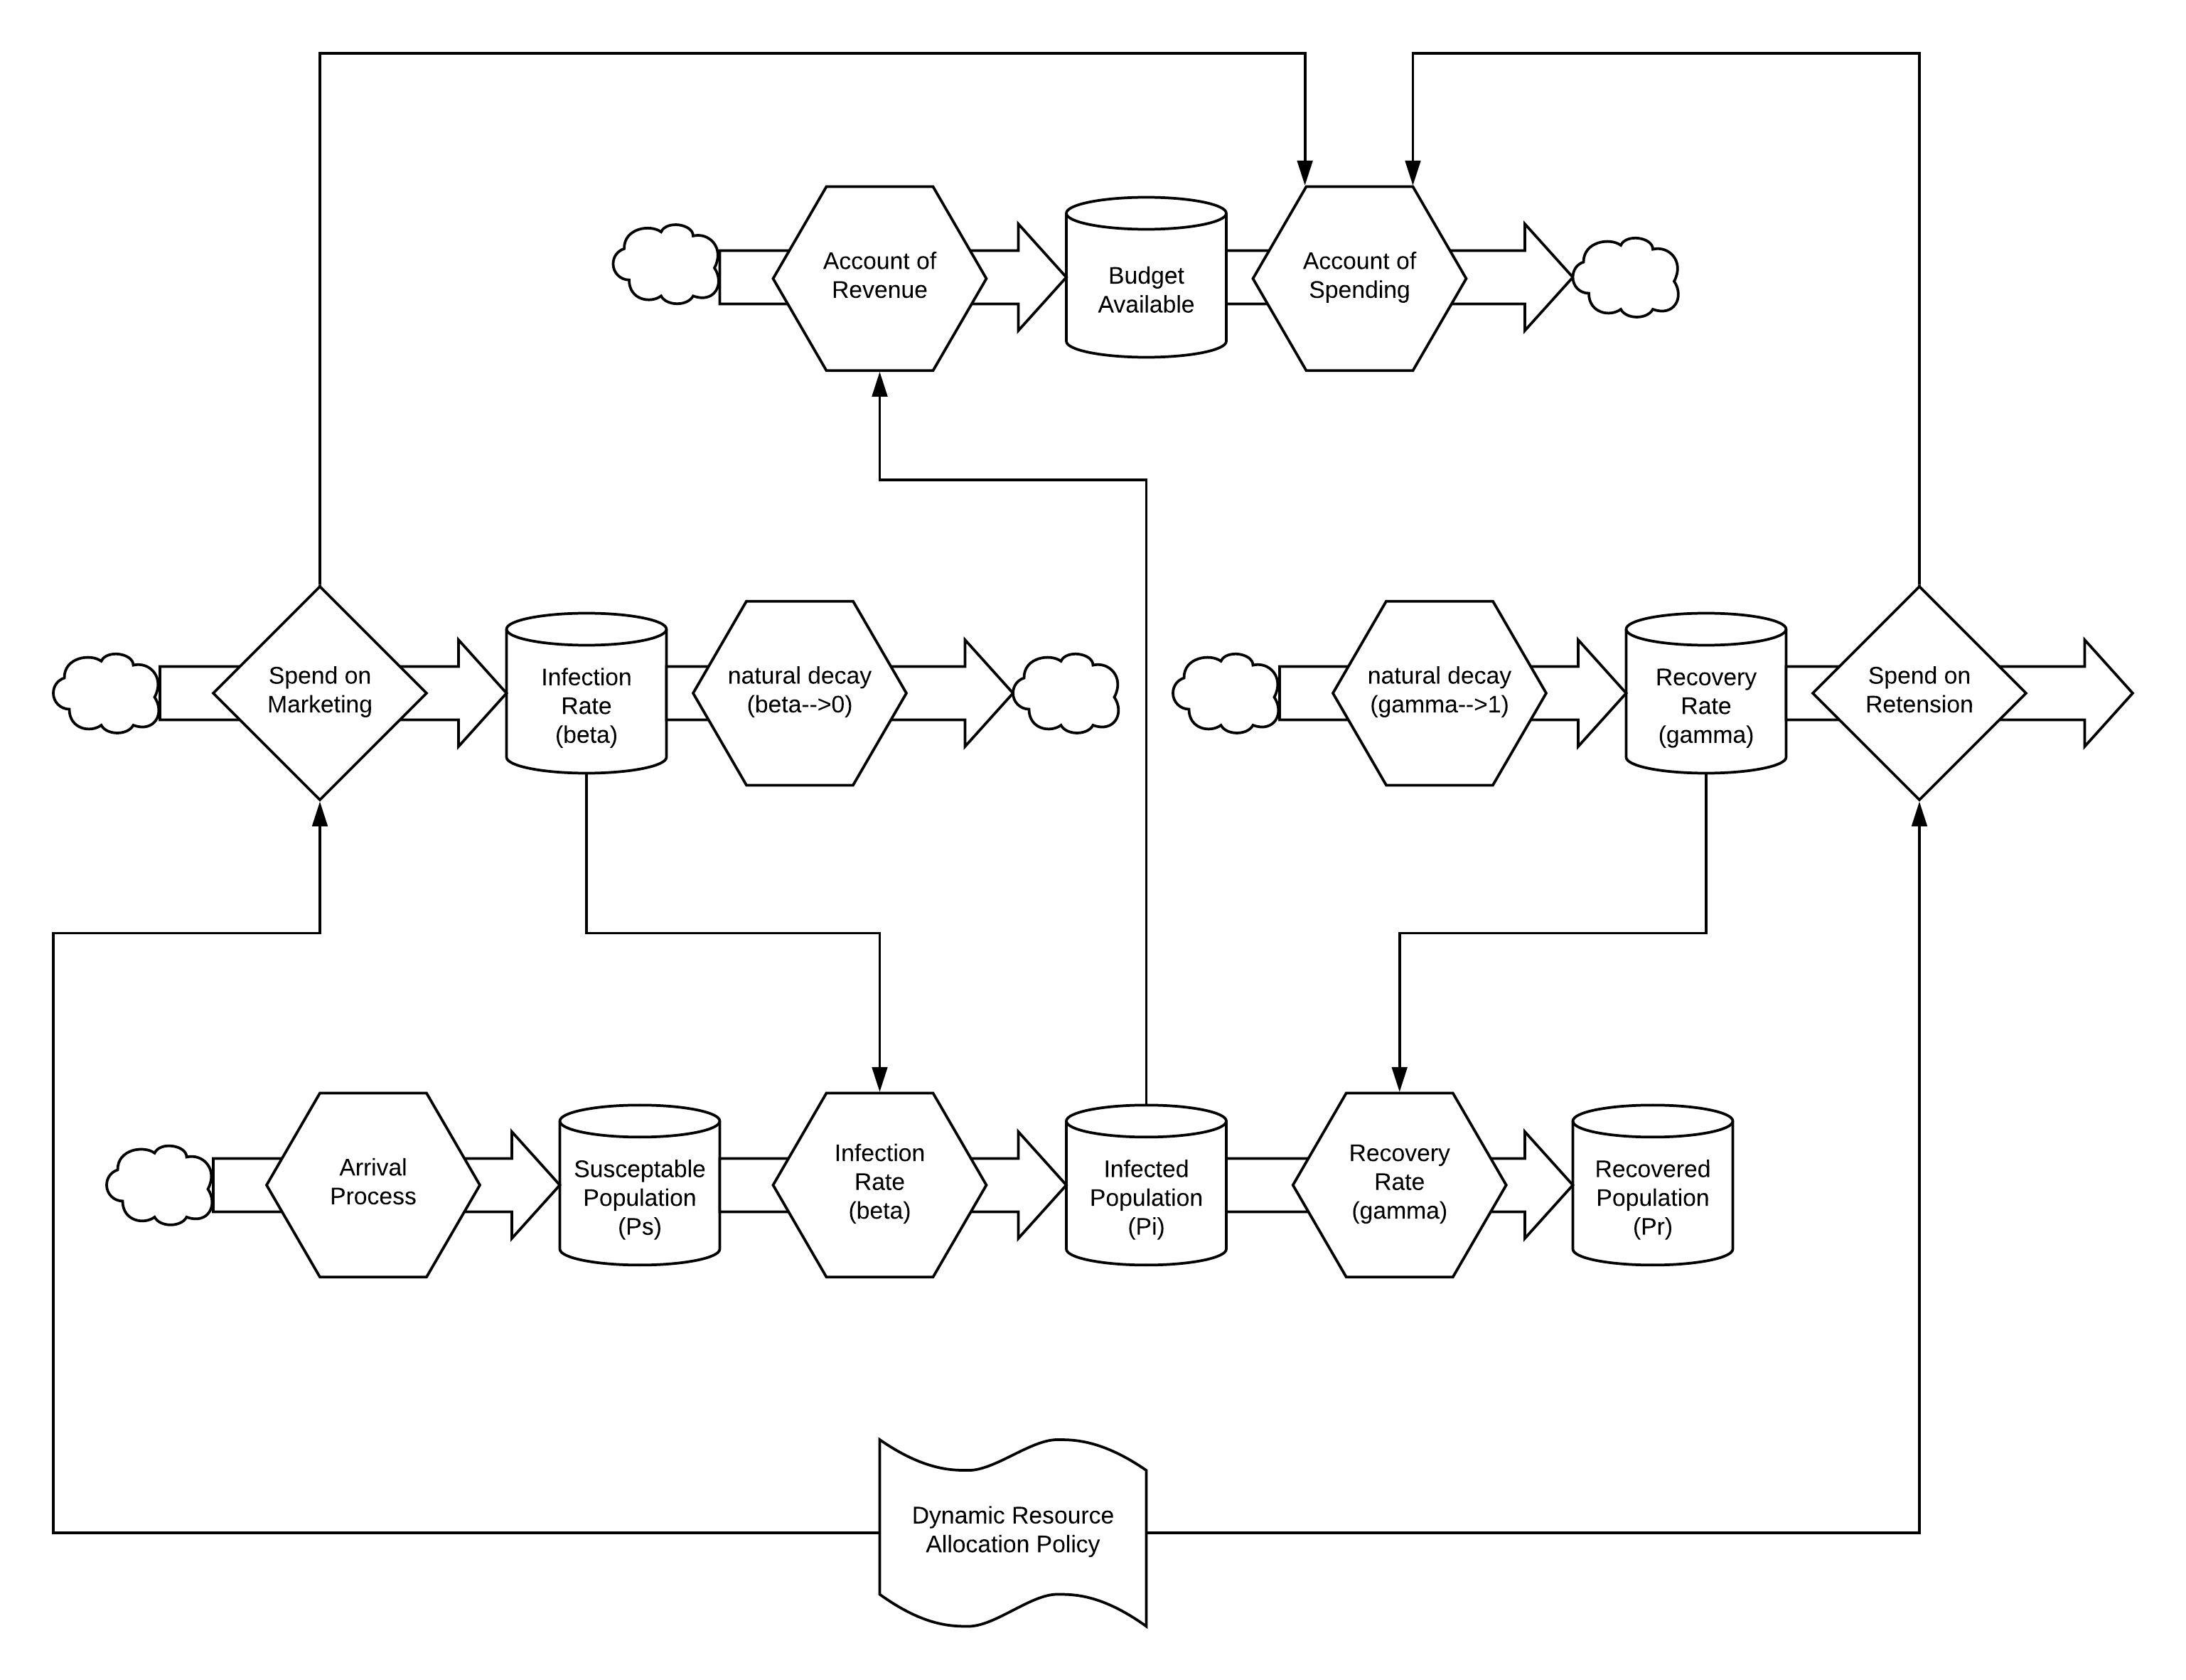

In [7]:
Image(filename='SIR.jpeg')

In [8]:
# Behaviors: hoose actions depending on states
# Define a dynamic resource allocation policy which will attempt to spend budget achieve goals
# 1) increase contact rate, beta (create incentive to spread)
# 2) decrease recover rate, gamma (improve stickiness)

#spend on Marketing & adoption incentives
def add_incentive(step, sL, s):
    incentive_allocation_as_share_of_budget = 0.1
    target_beta = .2
    potential_spend = s['Budget']*incentive_allocation_as_share_of_budget
    
    potential_delta = target_beta-s['beta']
    
    cost_of_potential_delta = potential_delta * incentive_cost * s['Ps']
    if cost_of_potential_delta <= potential_spend:
        delta = potential_delta
    else:
        delta = potential_spend/(incentive_cost * s['Ps'])

    return {'delta': delta}

#spend on retention 
def add_stickiness(step, sL, s):
    stickiness_allocation_as_share_of_budget = 0.4
    target_gamma = .01
    potential_spend = s['Budget']*stickiness_allocation_as_share_of_budget
    
    potential_delta = s['gamma']-target_gamma
    
    cost_of_potential_delta = potential_delta * stickiness_cost * s['Pi']
    if cost_of_potential_delta <= potential_spend:
        delta = potential_delta
    else:
        delta = potential_spend/(stickiness_cost * s['Pi'])
    
    return {'delta': delta}

Note that the polcies above are naive heuristics.  Bonus points: since the 'system model' or 'plant' is known, derive and implement an optimal control policy. The product adoption dynamics problem as stated has the same structure as epidemic prevention control problem but with the object reversed: https://arxiv.org/pdf/1503.03537.pdf

In [9]:
# Mechanisms incur cost to modify beta or gamma
# These mechanism have actions as inputs and changes to states as outputs
# 1) incur cost to create incentive to spread
# 2) incur cost to improve stickiness

# cost of 1)
def incur_incentive_cost(step, sL, s, _input):
    y = 'Budget'
    x = s['Budget'] - abs(_input['delta'] * s['Ps'] * incentive_cost)
    return (y, x)

# cost 2)
def incur_stickiness_cost(step, sL, s, _input):
    y = 'Budget'
    x = s['Budget'] - abs(_input['delta'] * s['Pi'] * stickiness_cost)
    return (y, x)

# impact of 1)
def update_beta(step, sL, s, _input):
    y = 'beta'
    x = s['beta'] + _input['delta']
    return (y, x)

# impact of 2)
def update_gamma(step, sL, s, _input):
    y = 'gamma'
    x = s['gamma'] - _input['delta']
    return (y, x)

In [10]:
#The SIR dynamical system has internal state dynamics which evolve
#without direct dependency on the actions output by behavoir polcies

#Environmental process for Susceptible population
lam = 25 #expected arrivals per period (parameter of poisson process)
def arrival_process(step, sL, s, _input):
    y = 'Ps'
    x = s['Ps']+poisson.rvs(lam)
    return (y, x)

#State Update of Susceptible Population (Ps) state from infection dynamics
def S_model(step, sL, s, _input):
    y = 'Ps'
    x = s['Ps'] - s['beta'] * s['Ps']
    return (y, x)

#State Update of Infected Population (Pi) state from infection dynamics
def I_model(step, sL, s, _input):
    y = 'Pi'
    x = s['Pi'] + s['beta'] * s['Ps'] - s['gamma'] * s['Pi']
    return (y, x)

#State Update of Recovered Population (Pr) state from infection dynamics
def R_model(step, sL, s, _input):
    y = 'Pr'
    x = s['Pr'] + s['gamma'] * s['Pi']
    return (y, x)

#Collect revenue and allocate to budget
#recall that epsilon is the share of revenue allocated to spend on incentives & stickiness
def collect_subscription(step, sL, s, _input):
    y = 'Budget'
    revenue = s['Pi']* subscription_fee
    x = s['Budget'] +  epsilon * revenue
    return (y, x)

#incentives provided to increase infection lose effectiveness over time
#infection rate loses "incentive_degredation_rate" fraction of beta during each period
#if left alone decays to 0 = no new infections
def incentive_degrade(step, sL, s, _input):
    y = 'beta'
    x = s['beta']*(1-incentive_degredation_rate)
    return (y, x)

#initiatives provided to decrease recovery lose effectiveness over time
#recover rate increases towards 1 at an exponetial rate characterized by "stickiness_degredation_rate"
#if left alone rises to 1 = all infect recover
def stickiness_degrade(step, sL, s, _input):
    y = 'gamma'
    x = (s['gamma']+stickiness_degredation_rate)/(1+stickiness_degredation_rate)
    return (y, x)


The Cell below contains the "mechanisms" object which defines the relationships between all the functions defined above. The first layer key contains the partial state update block. Within each partial state update block there are 'behavoirs' which contain references to decision policies which output actions and there are 'states' which contains references to state variables and to the mechanism functions which update those state variables; outputs from policies in the behavoirs field are passed as inputs to mechanisms used to update state variables. For more information see: https://github.com/BlockScience/SimCAD-Tutorials/blob/master/demos/robot-marbles-part-2/robot-marbles-part-2.ipynb

In [11]:
mechanisms = {
    'arrive': {
        'behaviors': {},
        'states': {
            'Ps': arrival_process, 
        }      
    },
    
    'spread': {
        'behaviors': {
        },
        'states': {
            'Ps': S_model,
            'Pi': I_model,
            'Pr': R_model,
            'Budget': collect_subscription,
            'beta': incentive_degrade,
            'gamma': stickiness_degrade 
        }      
    },
    'create_incentive': {
        'behaviors': {
            'action': add_incentive,
        },
        'states': {
            'beta': update_beta,
            'Budget': incur_incentive_cost,
        }
    },
    'improve_stickiness': {
        'behaviors': {
            'action': add_stickiness
        },
        'states': {
            'gamma': update_gamma,
            'Budget': incur_stickiness_cost,
        }
    }
}

In [12]:
#Standard block of code which packs all the definitions into a configuration
config = Configuration(
            sim_config=sim_config,
            state_dict=initial_condition,
            seed=seed,
            exogenous_states=exogenous_states,
            env_processes=env_processes,
            mechanisms=mechanisms)

#Standard block of code to import compilers and execute the simulations
from SimCAD.engine import ExecutionMode, ExecutionContext, Executor
exec_mode = ExecutionMode()
exec_context = ExecutionContext(exec_mode.single_proc)
executor = Executor(exec_context, [config]) # Pass the configuration object inside an array
raw_result, tensor = executor.main()
df = pd.DataFrame(raw_result)

single_proc: [<SimCAD.configuration.Configuration object at 0x1a21a0bcf8>]


In [13]:
#Explore the resulting data stored in the dataframe df
df.head(10)

,Budget,Pi,Pr,Ps,beta,gamma,mech_step,run,time_step,timestamp
0,500.000000,10.000000,0.0000,1000.000000,0.050000,0.200000,0,1,0,2019-01-01 00:00:00
1,500.000000,10.000000,0.0000,1015.000000,0.050000,0.200000,1,1,1,2019-01-31 00:00:00
2,503.000000,58.750000,2.0000,964.250000,0.049500,0.207921,2,1,1,2019-01-31 00:00:00
3,452.700000,58.750000,2.0000,964.250000,0.054716,0.207921,3,1,1,2019-01-31 00:00:00
4,394.560767,58.750000,2.0000,964.250000,0.054716,0.010000,4,1,1,2019-01-31 00:00:00
5,394.560767,58.750000,2.0000,992.250000,0.054716,0.010000,1,1,2,2019-03-02 00:00:00
6,412.185767,112.454937,2.5875,937.957563,0.054169,0.019802,2,1,2,2019-03-02 00:00:00
7,370.967191,112.454937,2.5875,937.957563,0.058564,0.019802,3,1,2,2019-03-02 00:00:00
8,365.455785,112.454937,2.5875,937.957563,0.058564,0.010000,4,1,2,2019-03-02 00:00:00
9,365.455785,112.454937,2.5875,954.957563,0.058564,0.010000,1,1,3,2019-04-01 00:00:00


In [14]:
#Pandas provides a host of basic explorative functions such as describe
df[['Ps','Pi', 'Pr']].describe()

,Ps,Pi,Pr
count,401.000000,401.000000,401.000000
mean,210.845541,1422.178861,580.556645
std,229.916373,485.178892,435.319399
min,93.143254,10.000000,0.000000
25%,101.662308,1272.054581,174.430909
50%,108.124814,1552.917071,529.065584
75%,136.387102,1779.795610,946.332695
max,1015.000000,1953.659420,1413.031863


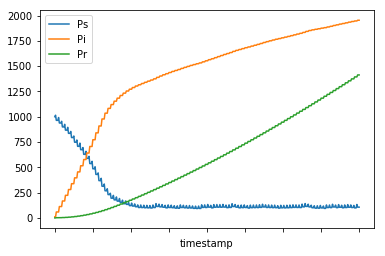

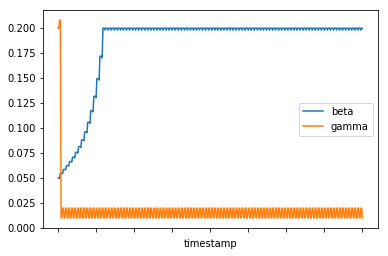

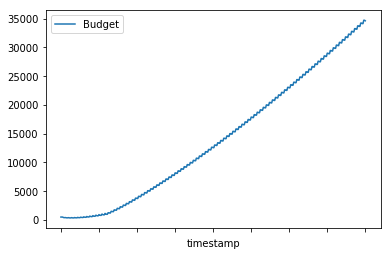

In [15]:
#and matplotlib inline with pandas allows easy visualization of the dynamics
df.plot('timestamp', ['Ps','Pi', 'Pr'])
df.plot('timestamp', ['beta', 'gamma'])
df.plot('timestamp', ['Budget'])

In [16]:
#thanks to the integration with the python data science stack more advanced analysis is easy
#the below is stats for the rates of change of beta
#by setting mech_step=1, we consider full period state updates measured from step 1 to step 1
df[df.mech_step==1].beta.diff().describe()

count    99.000000
mean      0.001515
std       0.004593
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max       0.028159
Name: beta, dtype: float64

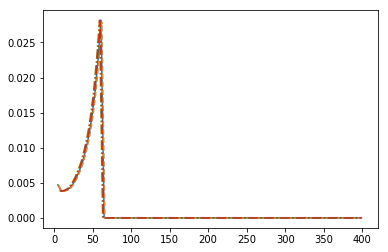

In [17]:
#and here is a quick plot for the rates of change of beta
#df.beta.diff().plot(linestyle='-')
df[df.mech_step==1].beta.diff().plot(linestyle='-')
df[df.mech_step==2].beta.diff().plot(linestyle='--')
df[df.mech_step==3].beta.diff().plot(linestyle='-.')
df[df.mech_step==4].beta.diff().plot(linestyle='-.')

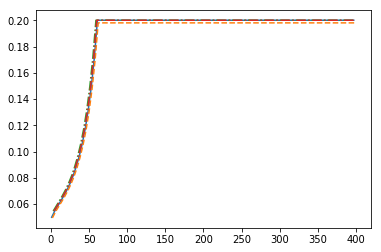

In [18]:
#and here is a quick plot for the values of beta
#exploring across mechanism steps helps see the way the simulation is implemented
df[df.mech_step==1].beta.plot(linestyle='-')
df[df.mech_step==2].beta.plot(linestyle='--')
df[df.mech_step==3].beta.plot(linestyle='-.')
df[df.mech_step==4].beta.plot(linestyle='-.')

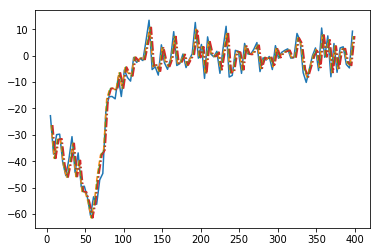

In [19]:
#and here is a quick plot for the values of beta
#since beta is the infection rate, look at the changes to Ps
#note the noise injected by the arrival process
df[df.mech_step==1].Ps.diff().plot(linestyle='-')
df[df.mech_step==2].Ps.diff().plot(linestyle='--')
df[df.mech_step==3].Ps.diff().plot(linestyle='-.')
df[df.mech_step==4].Ps.diff().plot(linestyle='-.')

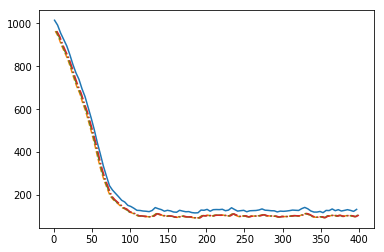

In [20]:
#and here is a quick plot for the values of beta
#finally observe the values of the susceptible population
#again note the effect of the noise injected by the arrival process
df[df.mech_step==1].Ps.plot(linestyle='-')
df[df.mech_step==2].Ps.plot(linestyle='--')
df[df.mech_step==3].Ps.plot(linestyle='-.')
df[df.mech_step==4].Ps.plot(linestyle='-.')

Having initial explored some of the aspects of the dynamical system with the original set of parameters, we've included a widget for playing around with the paramters and rerunning the one-off simulation with plots of the state variables automatically generated. Have fun!

In [25]:
def widget_handler(beta=float(0.0), gamma=float(0.75),
                   subscription_fee=float(1.0), 
                   incentive_cost=float(10.0), 
                   stickiness_cost=float(5.0)):
    initial_condition['beta'] = beta
    initial_condition['gamma'] = gamma
    subscription_fee = subscription_fee
    incentive_cost = incentive_cost
    stickiness_cost = stickiness_cost
    
    config = Configuration(
            sim_config=sim_config,
            state_dict=initial_condition,
            seed=seed,
            exogenous_states=exogenous_states,
            env_processes=env_processes,
            mechanisms=mechanisms)

    exec_mode = ExecutionMode()
    exec_context = ExecutionContext(exec_mode.single_proc)
    executor = Executor(exec_context, [config]) # Pass the configuration object inside an array
    raw_result, tensor = executor.main()
    df = pd.DataFrame(raw_result)
    df['timestamp'] = pd.to_datetime(df['timestamp'], format=ts_format)
    
    fig = plt.figure(figsize=(7, 14))
    
    sir = fig.add_subplot(3, 1, 1)
    sir.plot('timestamp', 'Ps', data=df, marker='', color='C0', linewidth=2)
    sir.plot('timestamp', 'Pi', data=df, marker='', color='orange', linewidth=2)
    sir.plot('timestamp', 'Pr', data=df, marker='', color='green', linewidth=2)
    sir.legend()
    
    beta_gamma = fig.add_subplot(3, 1, 2)
    beta_gamma.plot('timestamp', 'beta', data=df, marker='', color='C0', linewidth=2)
    beta_gamma.plot('timestamp', 'gamma', data=df, marker='', color='orange', linewidth=2)
    beta_gamma.legend()
    
    budget_pi = fig.add_subplot(3, 1, 3)
    budget_pi.plot('timestamp', 'Budget', data=df, marker='', color='C0', linewidth=2)
    #budget_pi.plot('timestamp', 'Pi', data=df, marker='', color='orange', linewidth=2)
    budget_pi.legend()
    
    plt.show()
    
sliders = interact_manual(widget_handler, 
                beta=(0, .25, 0.01),
                gamma=(.5, 1, 0.01),
                subscription_fee=(0, 10, 0.1),
                incentive_cost=(0, 20, 0.5),
                stickiness_cost=(0, 20, 0.5)
               )
sliders

interactive(children=(FloatSlider(value=0.0, description='beta', max=0.25, step=0.01), FloatSlider(value=0.75,…

<function __main__.widget_handler(beta=0.0, gamma=0.75, subscription_fee=1.0, incentive_cost=10.0, stickiness_cost=5.0)>